# Lecture 14 - GMMs continued; K-Means Clustering

In [1]:
from scipy.stats import multivariate_normal
import numpy as np
import numpy.random as npr

import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('seaborn-colorblind')

from IPython.display import Image

# Gaussian Mixture Models

A **Gaussian Mixture Model** or **GMM** is a probabilistic model that assumes a data likelihood to be a weighted sum of Gaussian distributions with unknown parameters.

$$p(\mathbf{x}) = \sum_{k=1}^K \pi_k N(\mathbf{x}|\mathbf{\mu}_k,\Sigma_k)$$

where $0 \leq \pi_k \leq 1$ and $\sum_{k=1}^K \pi_k = 1$.

## Optimizing GMM with the EM Algorithm

The observed data likelihood for a Gaussian Mixture Model (GMM) is

$$\mathcal{L}^0 = \prod_{i=1}^N \sum_{k=1}^K \pi_k \mathcal{N}(x_i|\mu_k, \Sigma_k)$$

**What hidden variables can we add to simplify this problem?**

* In this example, a hidden variable can be the label of the Gaussian from which $x_i$ was drawn from.

$$z_i: \text{label of the Gaussian from which $x_i$ was drawn from}$$

Then, assuming we have $\{z_i\}_{i=1}^N$, we can write the complete data likelihood:

$$\mathcal{L}^c = \prod_{i=1}^N \pi_{z_i}\mathcal{N}(x_i|\mathbf{\mu}_{z_i},\Sigma_{z_i})$$

Now we can iterate between the **E-step** and **M-step** of the EM algorithm until we find convergence or we have reached a threshold for a number of iterations.

# Optimization Function

We can now extent the optimization function:

\begin{align}
Q(\Theta,\Theta^t) &= E[\ln(\mathcal{L^c})|X,\Theta^t] \\
&= \sum_{\mathbf{z}} \ln(\mathcal{L^c}) P(z|X,\Theta^t) \\
&= \sum_{z_i=1}^K \ln(\mathcal{L^c}) P(\mathbf{z}_i|\mathbf{x}_i,\Theta^t)
\end{align}

**<font color=blue>E-step</font>**

In order to complete the E-STEP, we need to know how to compute $P(\mathbf{z}_i|\mathbf{x}_i,\Theta^t) = C_{ik}$. 
\begin{align}
P(\mathbf{z}_i|\mathbf{x}_i,\Theta^t) &= \frac{P(\mathbf{x}_i|\mathbf{z}_i,\Theta^t)P(\mathbf{z}_i|\Theta^t)}{P(\mathbf{x}_i|\Theta^t)} \\
&= \frac{P(\mathbf{x}_i|\mathbf{\mu}_{z_i}^t, \Sigma_{z_i}^t) \pi_{z_i}^t}{\sum_{z_i=1}^K \pi_{z_i}^t P(\mathbf{x}_i|\mathbf{\mu}_{z_i}^t, \Sigma_{z_i}^t)} \\
&= C_{ik}
\end{align}

This is called the **memberships** or **responsabilities** matrix, which contains the label assignment for point $x_i$ in each Gaussian component $k$.

**<font color=blue>M-step</font>**

In the **M-step**, we are going to use (and hold constant) the membership matrix $C_{ik}$ we learned from the E-step.

We will know estimate the new set of parameters $\Theta=\{\pi_k,\mu_k,\Sigma_k\}_{k=1}^K$ that maximize $Q(\Theta,\Theta^t)$, i.e.

$$\arg_{\mathbf{\Theta}}\max Q(\Theta,\Theta^t)$$

\begin{align}
Q(\Theta, \Theta^t) &= \sum_{z_i=1}^K \ln(\mathcal{L^c}) P(\mathbf{z}_i=k|\mathbf{x}_i,\Theta^t)\\
&= \sum_{k=1}^K \ln(\mathcal{L^c}) C_{ik}\\
&= \sum_{k=1}^K \sum_{i=1}^N \left( \ln(\pi_k) -\frac{1}{2}\ln(2\pi) -\frac{1}{2}\ln(\sigma_k^2) - \frac{1}{2\sigma^2_k}\Vert \mathbf{x}_i -\mu_k\Vert_2^2 \right) C_{ik}
\end{align}

### Solving for $\mu_k$

From last class:

$$\mu_k = \frac{\sum_{i=1}^N \mathbf{x}_i C_{ik}}{\sum_{i=1}^N C_{ik}}$$

* We can interpret this as a **weighted mean**, where the weights represent the likelihood of each point belonging to cluster $k$.

### Solving for $\sigma_k^2$

From last class:

$$\sigma_k = \frac{\sum_{i=1}^N C_{ik} \Vert x_i-\mu_k\Vert_2^2}{\sum_{i=1}^N C_{ik}}$$

* Again, assuming that the covariance of each cluster is isotropic, that is, $\Sigma_k = \sigma_k^2\mathbf{I}$.

* For the variance, this can be interpreted as how much each data point contributes to the k-th cluster.

### Solving for $\pi_k$

For $\pi_k$ we have the contraint that $\sum_{k=1}^K \pi_k =1$. Then we need to incorporate it into $Q(\Theta, \Theta^t)$ using Lagrange Multipliers.

$$Q_{\pi}(\Theta,\Theta^t) = Q(\Theta,\Theta^t) + \lambda \left(1 - \sum_{k=1}^K\pi_k\right)$$

where $\lambda$ is called the Lagrange multiplier.

\begin{align}
0 &= \frac{\partial Q_{\pi}(\Theta,\Theta^t)}{\partial \pi_k} \\
0 &= \sum_{i=1}^N C_{ik} \frac{1}{\pi_k} - \lambda \\
\pi_k &= \frac{\sum_{i=1}^N C_{ik}}{\lambda}
\end{align}

Since $\sum_k \pi_k = 1$, then:

\begin{align}
\sum_{k=1}^K \pi_k &= 1\\
\sum_{k=1}^K \frac{\sum_{i=1}^N C_{ik}}{\lambda} &= 1 \\
\lambda &= \sum_{i=1}^N \sum_{k=1}^K C_{ik}
\end{align}

So:

\begin{align}
\pi_k &= \frac{\sum_{i=1}^N C_{ik}}{\lambda} \\
\pi_k &= \frac{\sum_{i=1}^N C_{ik}}{\sum_{i=1}^N \sum_{k=1}^K C_{ik}} \\
&= \frac{\sum_{i=1}^N C_{ik}}{\sum_{i=1}^N 1}\text{, because }C_{ik} = \sum_{k=1}^K P(z_i = k|x_i,\Theta^t)\text{ is a (discrete) distribution}\\
&= \frac{\sum_{i=1}^N C_{ik}}{N}
\end{align}

* The $\pi_k$'s are summing up all its responsabilites over all data points.

## Implementation - Pseudo-Code

We now have everything we need to implement the EM algorithm for Gaussian Mixtures.

* The pseudo-code for the algorithm is:

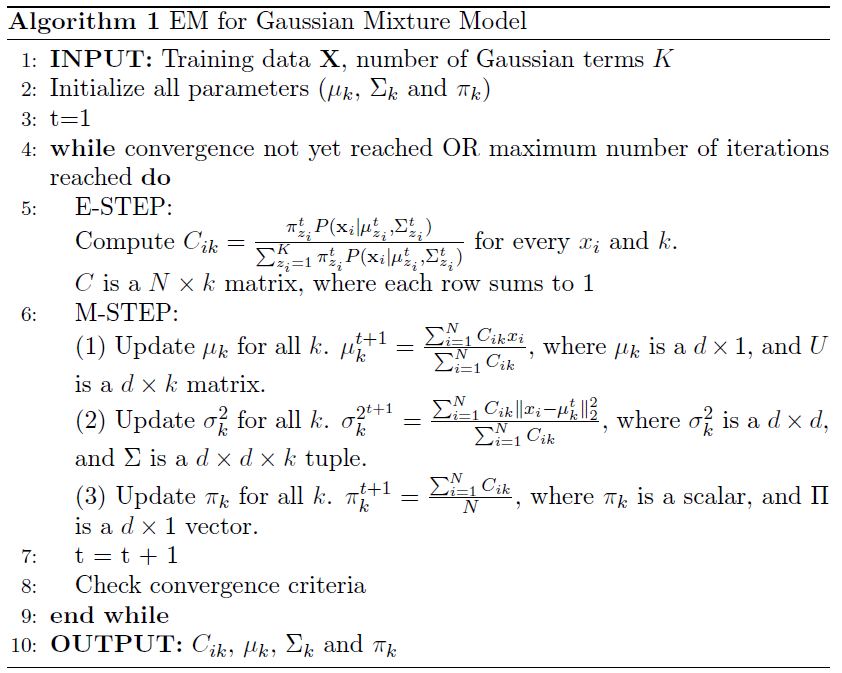

In [3]:
Image('figures/PseudoCode_EMforGMM.png',width=700)

## Alternating Optimization

* Does the EM algorithm find the **global minima**?

* Given a data set with an unknown number of groups/clusters, can you come up with a strategy for determining the "right" number of groups?

## Example: GMM as Data Likelihood Estimation or Clustering

GMM is commonly used as an algorithm for density estimation. That is to say, the result of a GMM fit to some data is technically not a clustering model, but a generative probabilistic model describing the distribution of the data.

However, a common practical use for the GMM is as a clustering algorithm, where we are interested in finding groups in the data.

Let's generate some data:

In [6]:
def make_GaussianMixture(N, Means, Sigs, Pis):
    X = np.empty((0,Means.shape[1]))
    L = np.empty(0)
    for i in range(N):
        rv = npr.uniform()   # sample uniform RV
        GaussianChosen = np.where(rv < np.cumsum(Pis))[0][0]
        L = np.append(L, GaussianChosen)
        X = np.append(X, np.array([npr.multivariate_normal(Means[GaussianChosen], 
                                                           np.eye(Means.shape[1])*Sigs[GaussianChosen])]), axis=0)
    return X, L

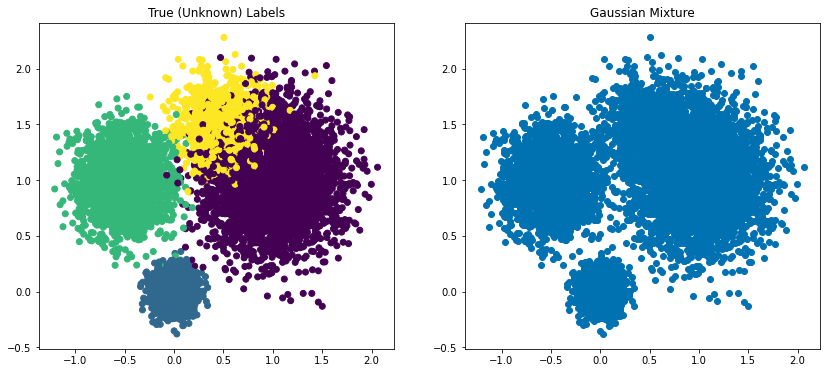

In [7]:
N = 10000
Means = np.array([[1,1],[0,0],[-.5, 1],[.5, 1.5]])
Sigs = [.1, .01, .05, .05]
Pis = [.4, .25, .25, .1]

X,L = make_GaussianMixture(N, Means, Sigs, Pis)

fig = plt.figure(figsize=(14,6))
fig.add_subplot(1,2,1)
plt.scatter(X[:,0],X[:,1], c=L)
plt.title('True (Unknown) Labels');
fig.add_subplot(1,2,2)
plt.scatter(X[:,0],X[:,1])
plt.title('Gaussian Mixture');

The picture on the left, represents the entire data color-coded according to a class they belong to.

In practice we are **not** given labels, and so we work directly with the unlabeled data set on the right.

* We can use GMM to uncover groups in the data.

To illustrate this, I will use the ```scikit-learn``` algorithm implementation of the GMM model:

In [10]:
from sklearn.mixture import GaussianMixture

In [11]:
?GaussianMixture

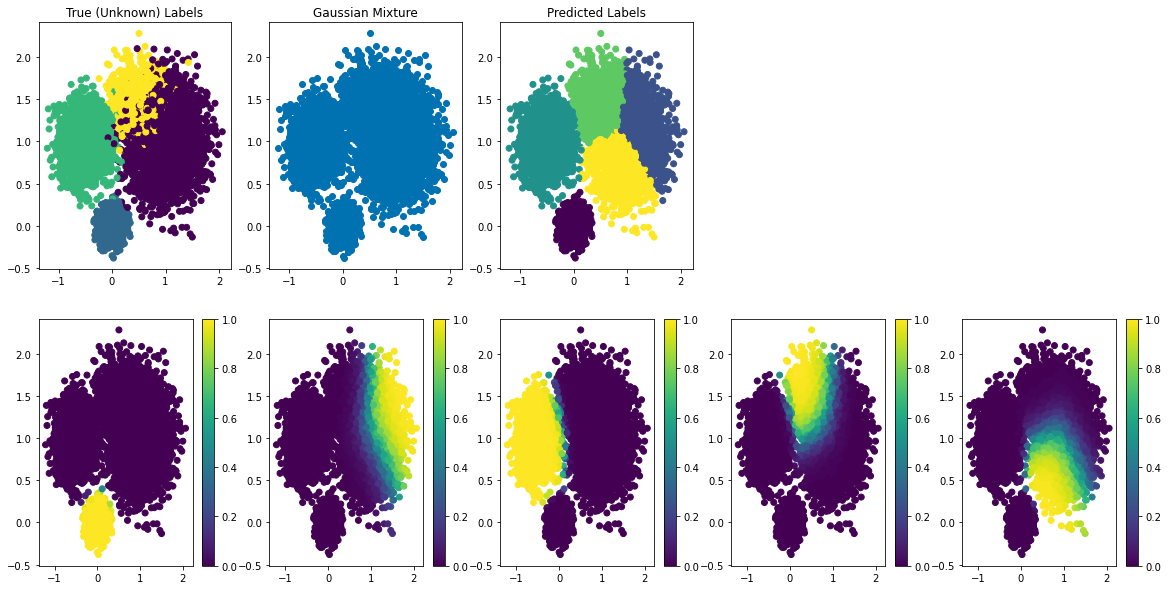

In [19]:
Nclusters = 5
GMM = GaussianMixture(n_components=Nclusters).fit(X)
labels = GMM.predict(X)
prob = GMM.predict_proba(X).round(2)

fig = plt.figure(figsize=(20,10))
fig.add_subplot(2,Nclusters,1)
plt.scatter(X[:,0],X[:,1], c=L)
plt.title('True (Unknown) Labels');
fig.add_subplot(2,Nclusters,2)
plt.scatter(X[:,0],X[:,1])
plt.title('Gaussian Mixture');
fig.add_subplot(2,Nclusters,3)
plt.scatter(X[:,0],X[:,1], c=labels)
plt.title('Predicted Labels');
for i in range(Nclusters):
    ax = fig.add_subplot(2,Nclusters,Nclusters+i+1)
    p1 = ax.scatter(X[:,0], X[:,1], c=prob[:,i])
    fig.colorbar(p1, ax=ax)

## Example: GMM as Density Estimation

Consider some data generated from Scikit-Learn's ```make_moons``` function:

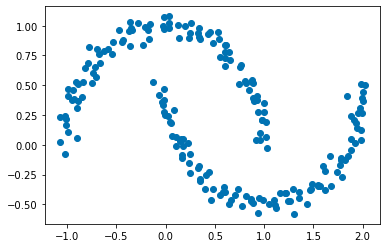

In [20]:
from sklearn.datasets import make_moons
from matplotlib.patches import Ellipse

Xmoon, ymoon = make_moons(200, noise=.05, random_state=0)
plt.scatter(Xmoon[:, 0], Xmoon[:, 1]);

Let's create a helper function that will help us visualize the locations and shapes of the GMM clusters by drawing ellipses based on the GMM output. 

* Let's not worry about the implementation of this helper function.

In [21]:
def draw_ellipse(position, covariance, ax=None, **kwargs):
    """Draw an ellipse with a given position and covariance"""
    ax = ax or plt.gca()
    
    # Convert covariance to principal axes
    if covariance.shape == (2, 2):
        U, s, Vt = np.linalg.svd(covariance)
        angle = np.degrees(np.arctan2(U[1, 0], U[0, 0]))
        width, height = 2 * np.sqrt(s)
    else:
        angle = 0
        width, height = 2 * np.sqrt(covariance)
    
    # Draw the Ellipse
    for nsig in range(1, 4):
        ax.add_patch(Ellipse(position, nsig * width, nsig * height,
                             angle, **kwargs))
        
def plot_gmm(gmm, X, label=True, ax=None):
    ax = ax or plt.gca()
    labels = gmm.fit(X).predict(X)
    if label:
        ax.scatter(X[:, 0], X[:, 1], c=labels, s=40, cmap='viridis', zorder=2)
    else:
        ax.scatter(X[:, 0], X[:, 1], s=40, zorder=2)
    ax.axis('equal')
    
    w_factor = 0.2 / gmm.weights_.max()
    for pos, covar, w in zip(gmm.means_, gmm.covariances_, gmm.weights_):
        draw_ellipse(pos, covar, alpha=w * w_factor)

If we try to fit this with a two-component GMM viewed as a clustering model, the results are not particularly useful:

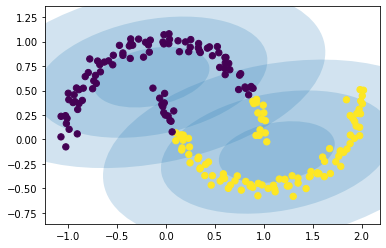

In [8]:
GMM = GaussianMixture(n_components=2, covariance_type='full', random_state=0).fit(Xmoon)
plot_gmm(GMM, Xmoon)

But if we instead use many more components and ignore the cluster labels, we find a fit that is much closer to the input data:

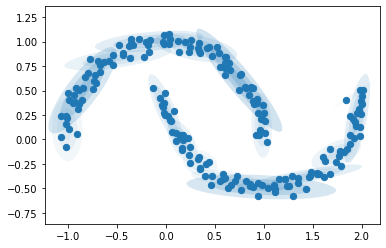

In [9]:
GMM16 = GaussianMixture(n_components=16, covariance_type='full', random_state=0).fit(Xmoon)
plot_gmm(GMM16, Xmoon, label=False)

Here the mixture of 16 Gaussians serves not to find separated clusters of data, but rather to model the overall distribution of the input data. This is a generative model of the distribution, meaning that the GMM gives us the recipe to generate new random data distributed similarly to our input. 

For example, here are 400 new points drawn from this 16-component GMM fit to our original data:

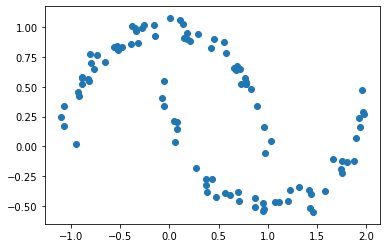

In [11]:
Xnew = GMM16.sample(100)
plt.scatter(Xnew[0][:, 0], Xnew[0][:, 1]);

GMM is convenient as a flexible means of modeling an arbitrary multi-dimensional distribution of data.

# Clustering

<div class="alert alert-success">
    <b>Clustering</b>
    
Clustering is a type of *unsupervised* Machine Learning technique. Clustering algorithms seek to learn, from the properties of the data, an optimal division or discrete labeling of groups of points.
</div>

Suppose you collect pictures of the following objects:

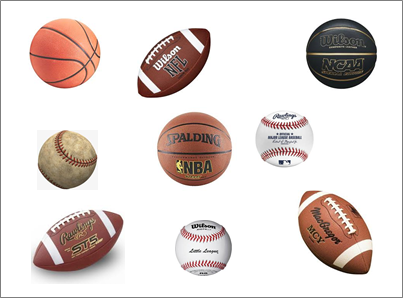

In [6]:
Image('figures/ClusteringExample.png', width=600)

* The goal in clustering is to partition the data into groups. 
    * How many groups would you partition this data into?

* We will first need to collect/extract features that characterize each object in each image.

* Then we can represent each image as a collection of features (in our polynomial regression problem, we use polynomial features, but we can use *any* basis function to characterize the data).

* In the feature space, we want to find partitions of the data. (In some cases we want to partition the original space - the input space of the images.)

* We have seen before that we can use *Gaussian Mixture Models* to characterize the data and then consider each Gaussian as distribution representation of each group.

Another popular clustering algorithm that takes a **non-parametric** form is called the **K-Means Algorithm**.

## K-Means Algorithm

K-Means algorithm is an iterative algorithm that tries to partition the dataset into $K$ pre-defined distinct non-overlapping subgroups (clusters) where each data point belongs to **only one group**. 

* It tries to make the *inter-cluster* data points as similar as possible while also keeping the clusters as different (far) as possible.

* It assigns data points to a cluster such that the sum of the squared distance between the data points and the cluster's centroid (arithmetic mean of all data points that belong to that cluster) is at the minimum.

* The less variation we have within clusters, the more homogenous (similar) the data points are within the same cluster.

The **pseudo-code** is summarized as follows:

1. Specify number of clusters $K$

2. Initialize centroids by first shuffling the dataset amd then randomly selecting $K$ data points for the centroids without replacement. (There are different ways of initializing the centroids)

3. Keep iterating until there is no change to the centroids, i.e., assignment of data points to clusters isn't changing.
    * Compute the sum of the squared distance between data points and all centroids
    * Assign each data pint to the closest cluster (centroid)
    * Compute the centroids for the clusters by taking the average of all data points that belong to each cluster
    

<div><img src="figures/KMeans.png", width="600"><!div>

The K-Means algorithm uses **Expectation-Maximization (EM) as the optimization approach**:
* The E-Step is assigning that data points to the closest cluster
* The M-step is computing the centroid of each cluster

As we learned before, optimization with EM is called **Alternating Optimization** and therefore the final solution will be **dependent** on the initialization (of cluster centroids). Therefore the final solution may not be the *optimal* (also referred to as *global*) solution.

* The objective function for the K-Means algorithm is:

\begin{align}
J(\Theta,U) &= \sum_{i=1}^N\sum_{k=1}^K u_{ik} d^2\left(x_i, \theta_k\right)\\
&= \sum_{i=1}^N\sum_{k=1}^K u_{ik} \Vert x_i - \theta_k\Vert_2^2\\
\text{ such that } & u_{ik}\in\{0,1\}\text{ and }\sum_{k=1}^K u_{ik} = 1
\end{align}

where $u_{ij}$ are cluster assignments, $\theta_j$ is the $j^{th}$ cluster representative and $d\left(x_i,\theta_k\right)$ is the distance between data point $x_i$ and cluster centroid $\theta_k$.

* In K-Means, we want to optimize:

$$\arg_{\Theta,U}\min J(\Theta,U)$$


* Does the K-means algorithm make any assumptions on cluster shape?
* Given a data set with an unknown number of clusters, can you come up with a strategy for determining the *right* number of clusters?
* Can we use other distance metrics in objective function $J(\Theta,U)$?